In [2]:
# 1.1 Importar librerías de análisis de datos
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from itertools import combinations
from scipy.stats import chi2_contingency
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import mutual_info_classif
import missingno as msno

In [3]:
# 2.1 Cargar dataset desde CSV
df = pd.read_csv("/content/dataset_elpino.csv", delimiter=';', encoding='utf-8', na_values='-')

# 2.2 Procesar columna GRD original
df['GRD'] = df['GRD'].str.split(' - ').str[0]

# 2.3 Crear columna GRD_trunc eliminando último dígito
df['GRD_trunc'] = df['GRD'].astype(str).str[:-1]

In [4]:
# 4.1 Definir función para calcular Cramér's V entre dos variables categóricas
def cramers_v(x, y):
    cm = pd.crosstab(x, y)
    chi2 = chi2_contingency(cm)[0]
    n = cm.values.sum()
    phi2 = chi2 / n
    r, k = cm.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

     Variable  Cramers_V
0      Diag 1   0.798011
1    Proced 1   0.505132
2      Diag 2   0.426026
3      Diag 3   0.305822
4    Proced 2   0.301294
5      Diag 4   0.253513
6      Diag 5   0.228891
7    Proced 3   0.205664
8      Diag 6   0.186256
9    Proced 4   0.175915
10     Diag 7   0.168499
11     Diag 9   0.158396
12   Proced 5   0.152214
13  Proced 29   0.145191
14    Diag 12   0.143930


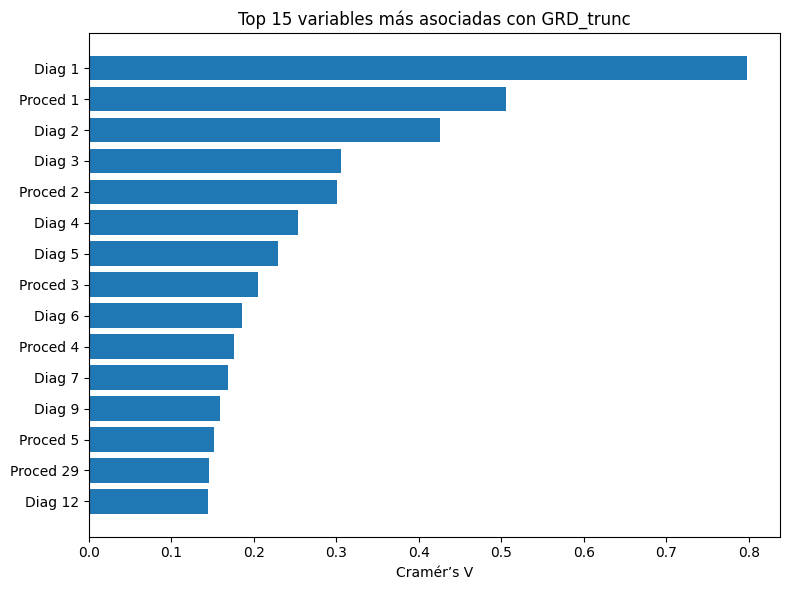

In [29]:
# 5.1 Calcular Cramér's V para cada variable respecto a GRD_trunc
diag_cols = [col for col in df.columns if col.startswith('Diag')]
proc_cols = [col for col in df.columns if col.startswith('Proced')]
variables = diag_cols + proc_cols
results = {
    var: cramers_v(df[var].astype(str), df['GRD_trunc'])
    for var in variables
}

# 5.2 Crear DataFrame con los 15 valores más altos de Cramér's V
df_results = (
    pd.DataFrame.from_dict(results, orient='index', columns=['Cramers_V'])
      .sort_values(by='Cramers_V', ascending=False)
      .head(15)
      .reset_index()
      .rename(columns={'index': 'Variable'})
)

# 5.3 Mostrar resultados de Cramér's V
print(df_results)

plt.figure(figsize=(8, 6))
plt.barh(df_results['Variable'], df_results['Cramers_V'])
plt.xlabel("Cramér’s V")
plt.title("Top 15 variables más asociadas con GRD_trunc")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

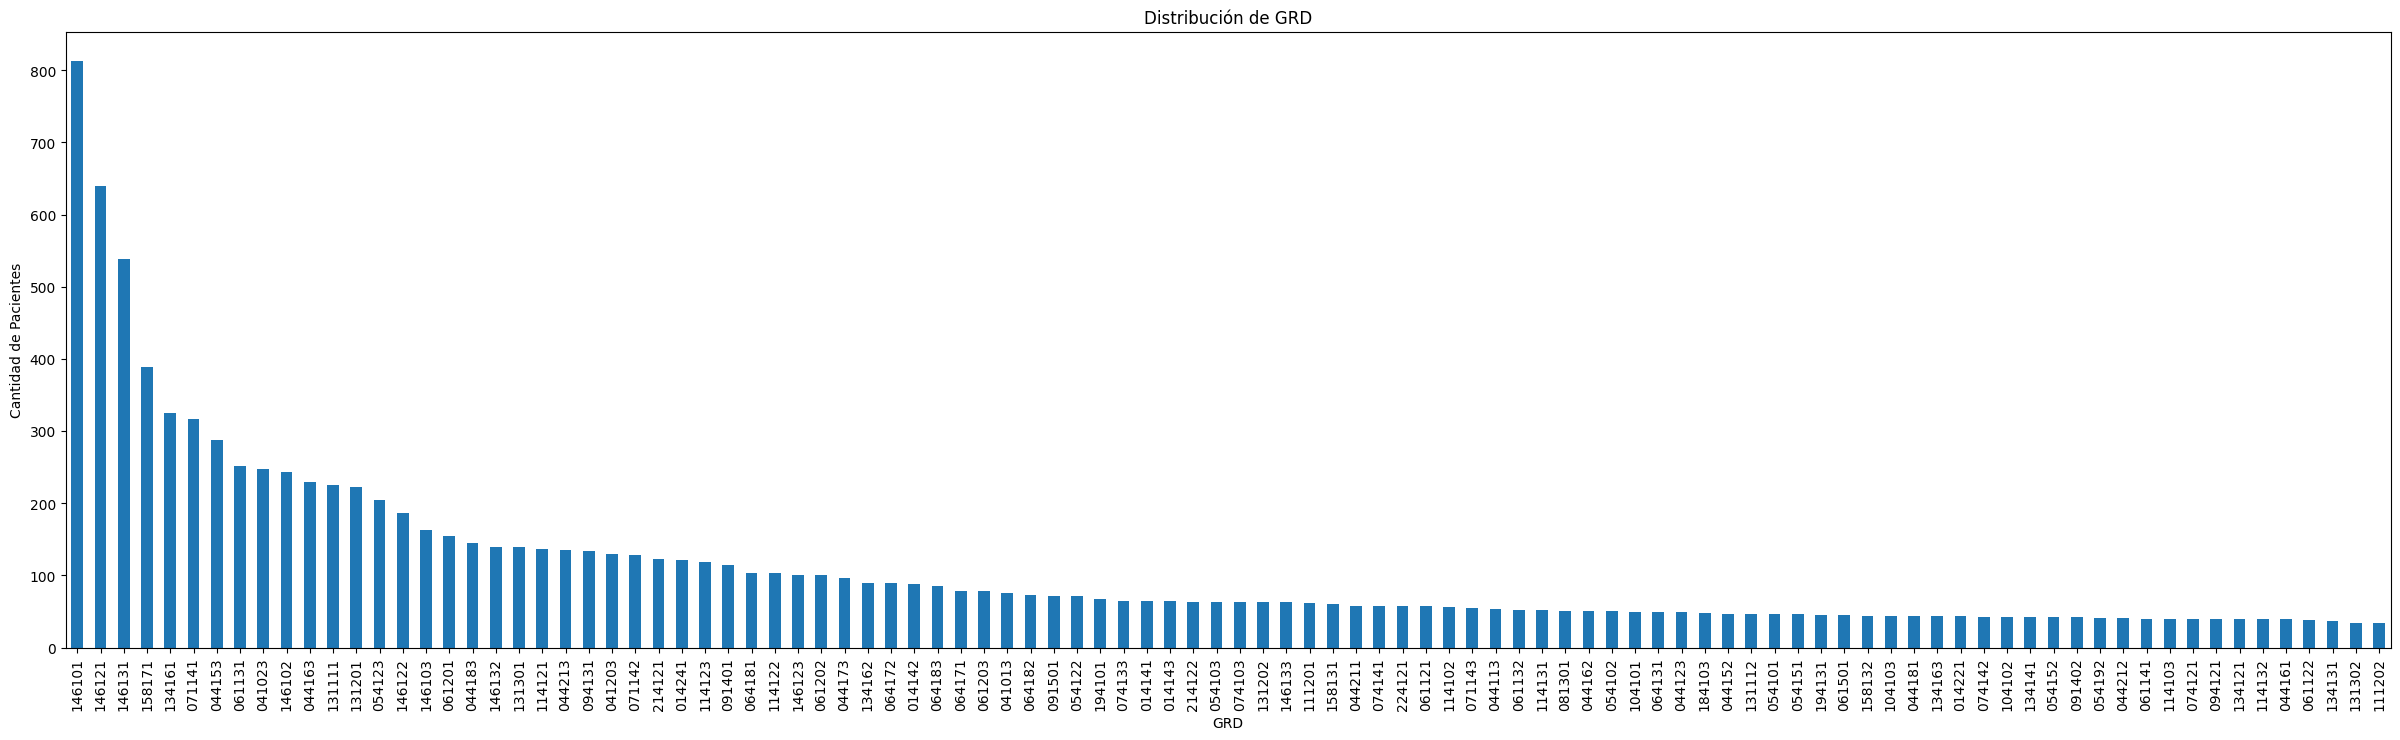

In [11]:
# 6.1 Seleccionar las 100 GRD más frecuentes
top100_grd = df['GRD'].value_counts().head(100)

# 6.2 Graficar distribución de las 100 GRD más frecuentes
plt.figure(figsize=(30,8))
top100_grd.plot(kind='bar')
plt.title('Distribución de GRD')
plt.ylabel('Cantidad de Pacientes')
plt.xticks(rotation=90)
plt.show()

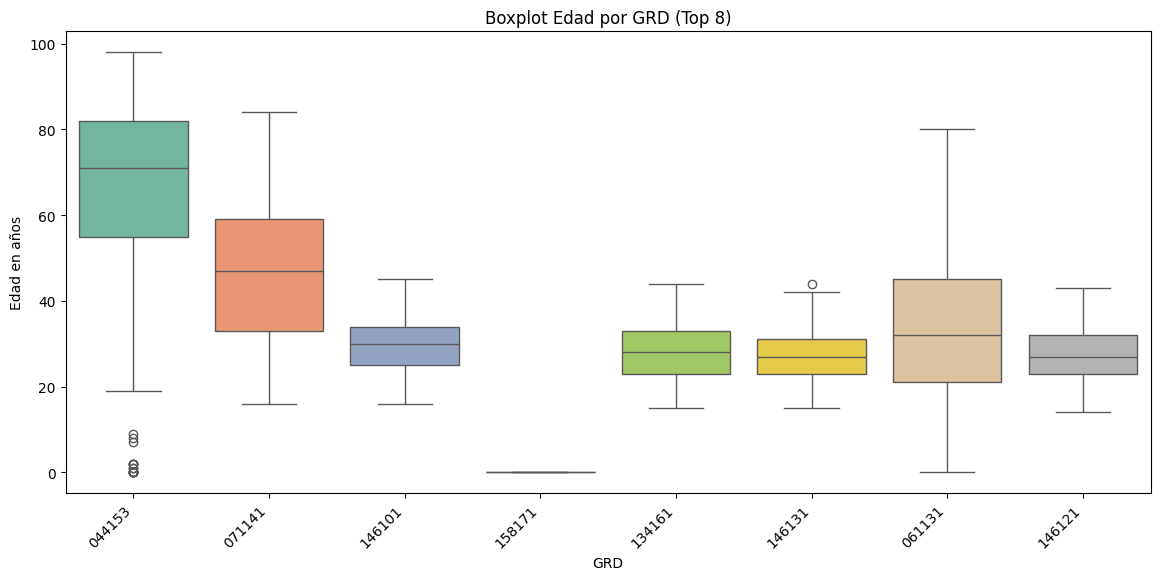

In [12]:
# 7.1 Obtener top 8 GRD para análisis de edades
top_grds = df['GRD'].value_counts().nlargest(8).index
df_top_grds = df[df['GRD'].isin(top_grds)]

# 7.2 Graficar boxplot de edad por GRD (Top 8)
plt.figure(figsize=(14,6))
sns.boxplot(data=df_top_grds, x='GRD', y='Edad en años', hue='GRD', palette="Set2", legend=False)
plt.xticks(rotation=45, ha='right')
plt.title('Boxplot Edad por GRD (Top 8)')
plt.show()

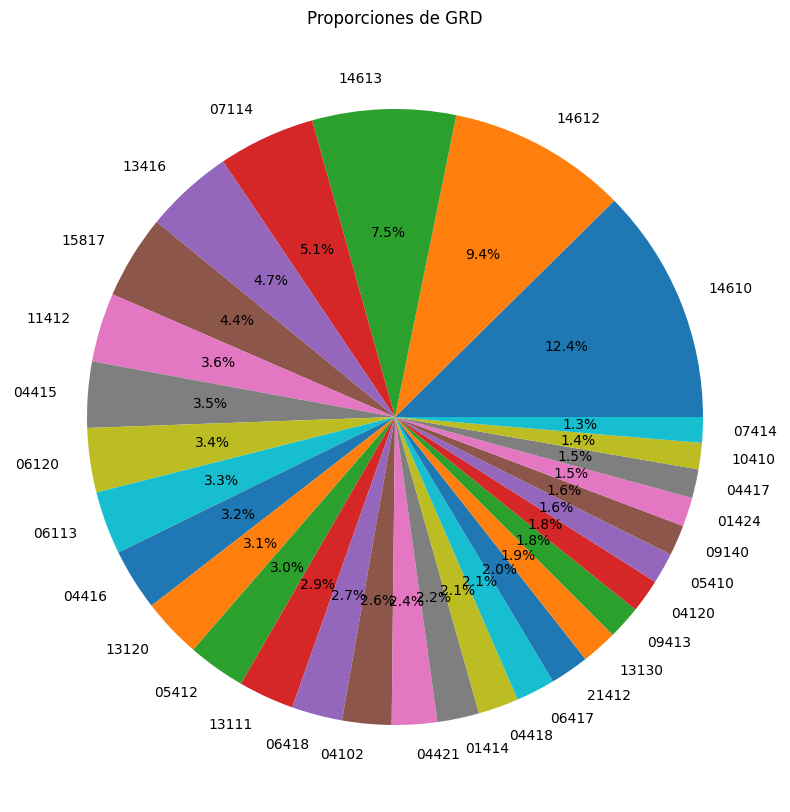

In [13]:
# 8.1 Preparar datos para gráfico de pastel (top 30 GRD_trunc)
plt.figure(figsize=(10,10))
top30 = df['GRD_trunc'].value_counts().head(30)
top30.plot.pie(autopct='%1.1f%%', legend=False)
plt.title('Proporciones de GRD')
plt.ylabel('')
plt.show()

In [14]:
# 9.1 Definir función para extraer código antes de " - "
def extraer_codigo(val):
    if pd.isna(val):
        return None
    return val.split(' - ')[0].strip()

# 9.2 Aplicar extracción de códigos a columnas de diagnóstico y procedimiento
columnas_diag = [col for col in df.columns if col.startswith("Diag")]
columnas_proced = [col for col in df.columns if col.startswith("Proced")]
df_diag_codigos = df[columnas_diag].map(extraer_codigo)
df_proced_codigos = df[columnas_proced].map(extraer_codigo)

# 9.3 Crear columna de diagnóstico principal y lista de procedimientos
df['diag_principal'] = df_diag_codigos['Diag 01 Principal (cod+des)']
df['procedimientos_lista'] = df_proced_codigos.apply(lambda row: [p for p in row if pd.notna(p)], axis=1)

# 9.4 Contar número de procedimientos por paciente
df['n_procedimientos'] = df['procedimientos_lista'].apply(len)

# 9.5 Renombrar columnas de sexo y edad para conveniencia
df['sexo'] = df['Sexo (Desc)']
df['edad'] = df['Edad en años']

In [15]:
# 10.1 Definir función para clasificar grupo etario según edad
def clasificar_grupo_etario(edad):
    if pd.isna(edad):
        return 'Desconocido'
    e = int(edad)
    if e <= 5:
        return 'Primera infancia'
    elif e <= 11:
        return 'Infancia'
    elif e <= 18:
        return 'Adolescencia'
    elif e <= 26:
        return 'Juventud'
    elif e <= 59:
        return 'Adultez'
    else:
        return 'Persona mayor'

# 10.2 Aplicar clasificación de grupo etario
df['grupo_etario'] = df['edad'].apply(clasificar_grupo_etario)

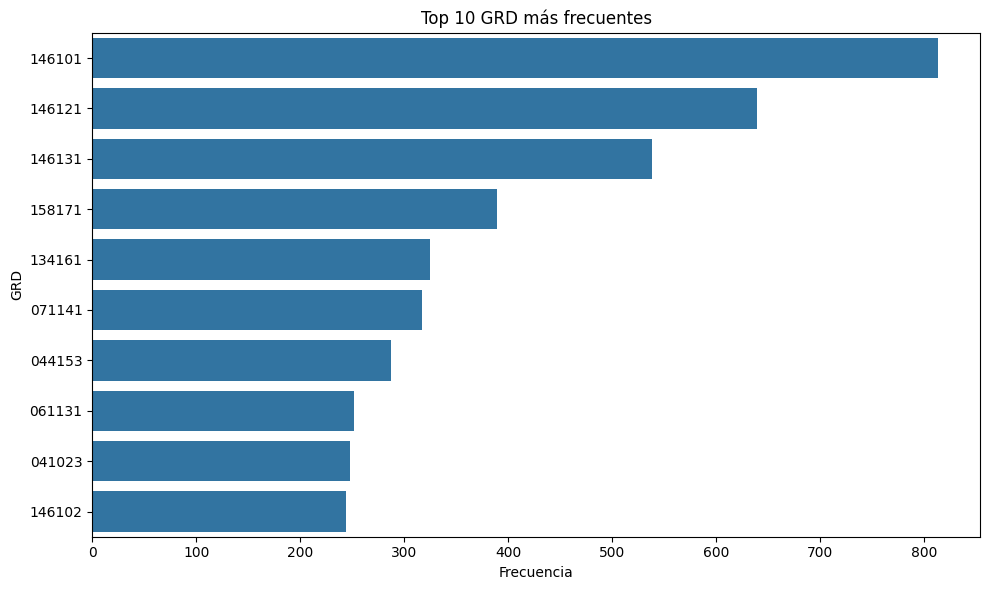

In [16]:
# 11.1 Preparar datos para gráfico Top 10 GRD
plt.figure(figsize=(10,6))
top10_grd = df['GRD'].value_counts().head(10)

# 11.2 Graficar Top 10 GRD por frecuencia
sns.barplot(x=top10_grd.values, y=top10_grd.index)
plt.title("Top 10 GRD más frecuentes")
plt.xlabel("Frecuencia")
plt.ylabel("GRD")
plt.tight_layout()
plt.show()

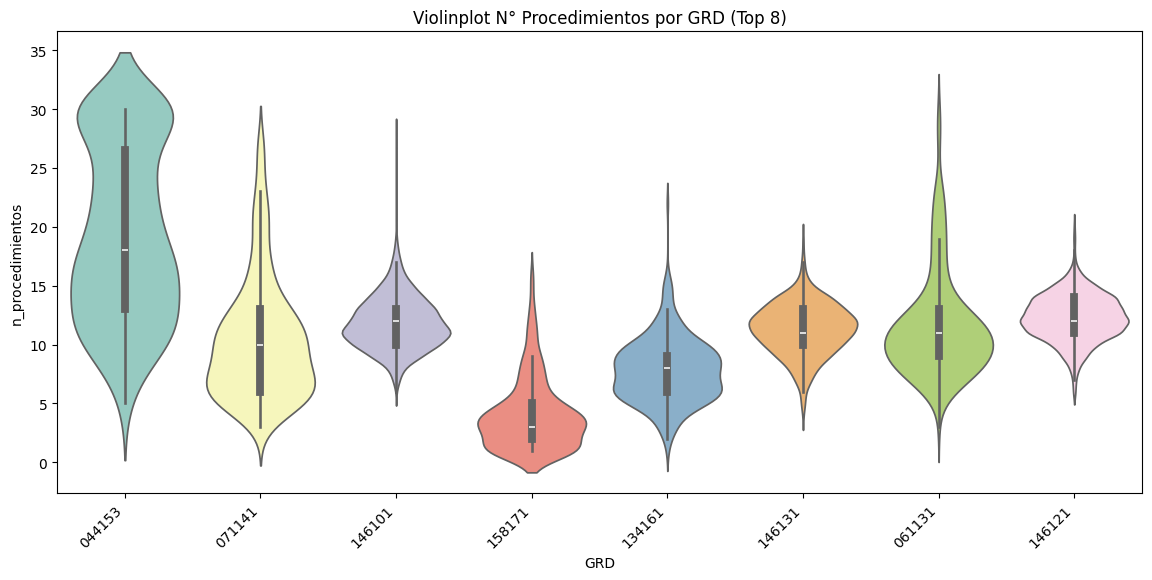

In [17]:
# 12.1 Graficar violinplot de número de procedimientos por GRD (Top 8)
plt.figure(figsize=(14,6))
sns.violinplot(data=df_top_grds, x='GRD', y=df['n_procedimientos'], hue='GRD', palette="Set3", legend=False)
plt.xticks(rotation=45, ha='right')
plt.title('Violinplot N° Procedimientos por GRD (Top 8)')
plt.show()

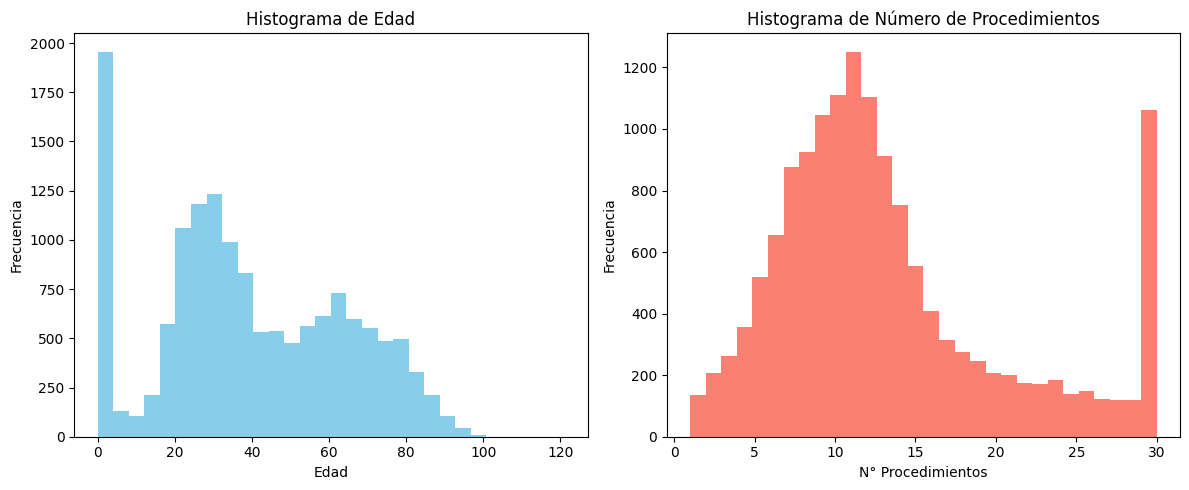

In [18]:
# 13.1 Graficar histogramas de edad y número de procedimientos
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.hist(df['Edad en años'].dropna(), bins=30, color='skyblue')
plt.title('Histograma de Edad')
plt.xlabel('Edad')
plt.ylabel('Frecuencia')
plt.subplot(1,2,2)
plt.hist(df['n_procedimientos'], bins=30, color='salmon')
plt.title('Histograma de Número de Procedimientos')
plt.xlabel('N° Procedimientos')
plt.ylabel('Frecuencia')
plt.tight_layout()
plt.show()

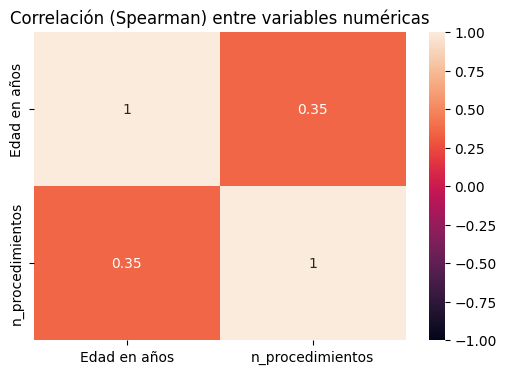

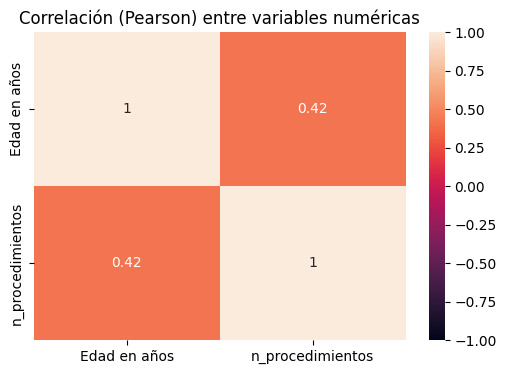

In [19]:
# 14.1 Calcular matriz de correlación Spearman para variables numéricas
corr_spearman = df[['Edad en años', 'n_procedimientos']].corr(method='spearman')

# 14.2 Graficar heatmap de correlación Spearman
plt.figure(figsize=(6,4))
sns.heatmap(corr_spearman, annot=True, vmin=-1, vmax=1)
plt.title('Correlación (Spearman) entre variables numéricas')
plt.show()

# 14.3 Calcular matriz de correlación Pearson para variables numéricas
corr_pearson = df[['Edad en años', 'n_procedimientos']].corr(method='pearson')

# 14.4 Graficar heatmap de correlación Pearson
plt.figure(figsize=(6,4))
sns.heatmap(corr_pearson, annot=True, vmin=-1, vmax=1)
plt.title('Correlación (Pearson) entre variables numéricas')
plt.show()


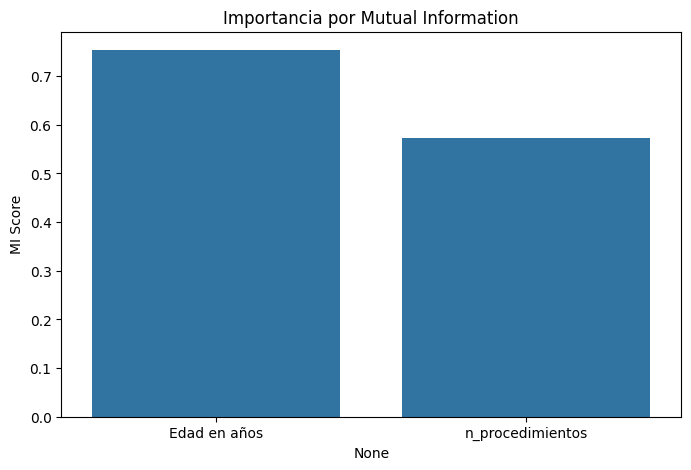

In [20]:
# 15.1 Preparar datos de entrada (X) y vector objetivo (y) para modelado
df_model = df[['Edad en años', 'n_procedimientos', 'Sexo (Desc)', 'GRD']].dropna()
X = df_model[['Edad en años', 'n_procedimientos']]
y_enc = LabelEncoder().fit_transform(df_model['GRD'])

# 15.2 Calcular información mutua para cada variable
mi = mutual_info_classif(X, y_enc, discrete_features=False)

# 15.3 Graficar importancia por información mutua
plt.figure(figsize=(8,5))
sns.barplot(x=X.columns, y=mi)
plt.title('Importancia por Mutual Information')
plt.ylabel('MI Score')
plt.show()

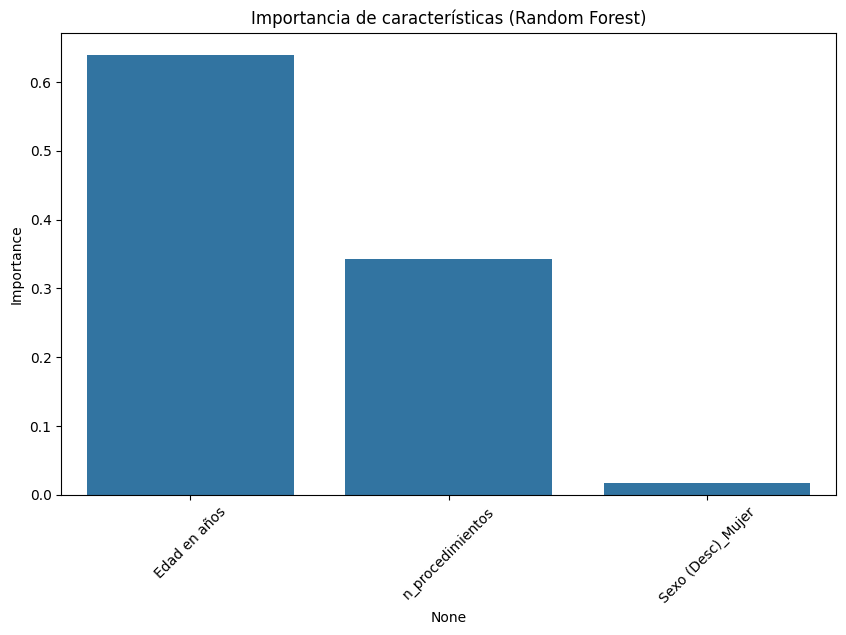

In [21]:
# 16.1 Preparar datos codificados para RandomForest
X_rf = pd.get_dummies(df_model[['Edad en años','n_procedimientos','Sexo (Desc)']], drop_first=True)

# 16.2 Entrenar RandomForest y obtener importancias
model_rf = RandomForestClassifier(n_estimators=100, random_state=0)
model_rf.fit(X_rf, y_enc)
importances = model_rf.feature_importances_

# 16.3 Graficar importancias de RandomForest
plt.figure(figsize=(10,6))
sns.barplot(x=X_rf.columns, y=importances)
plt.title('Importancia de características (Random Forest)')
plt.ylabel('Importance')
plt.xticks(rotation=45)
plt.show()

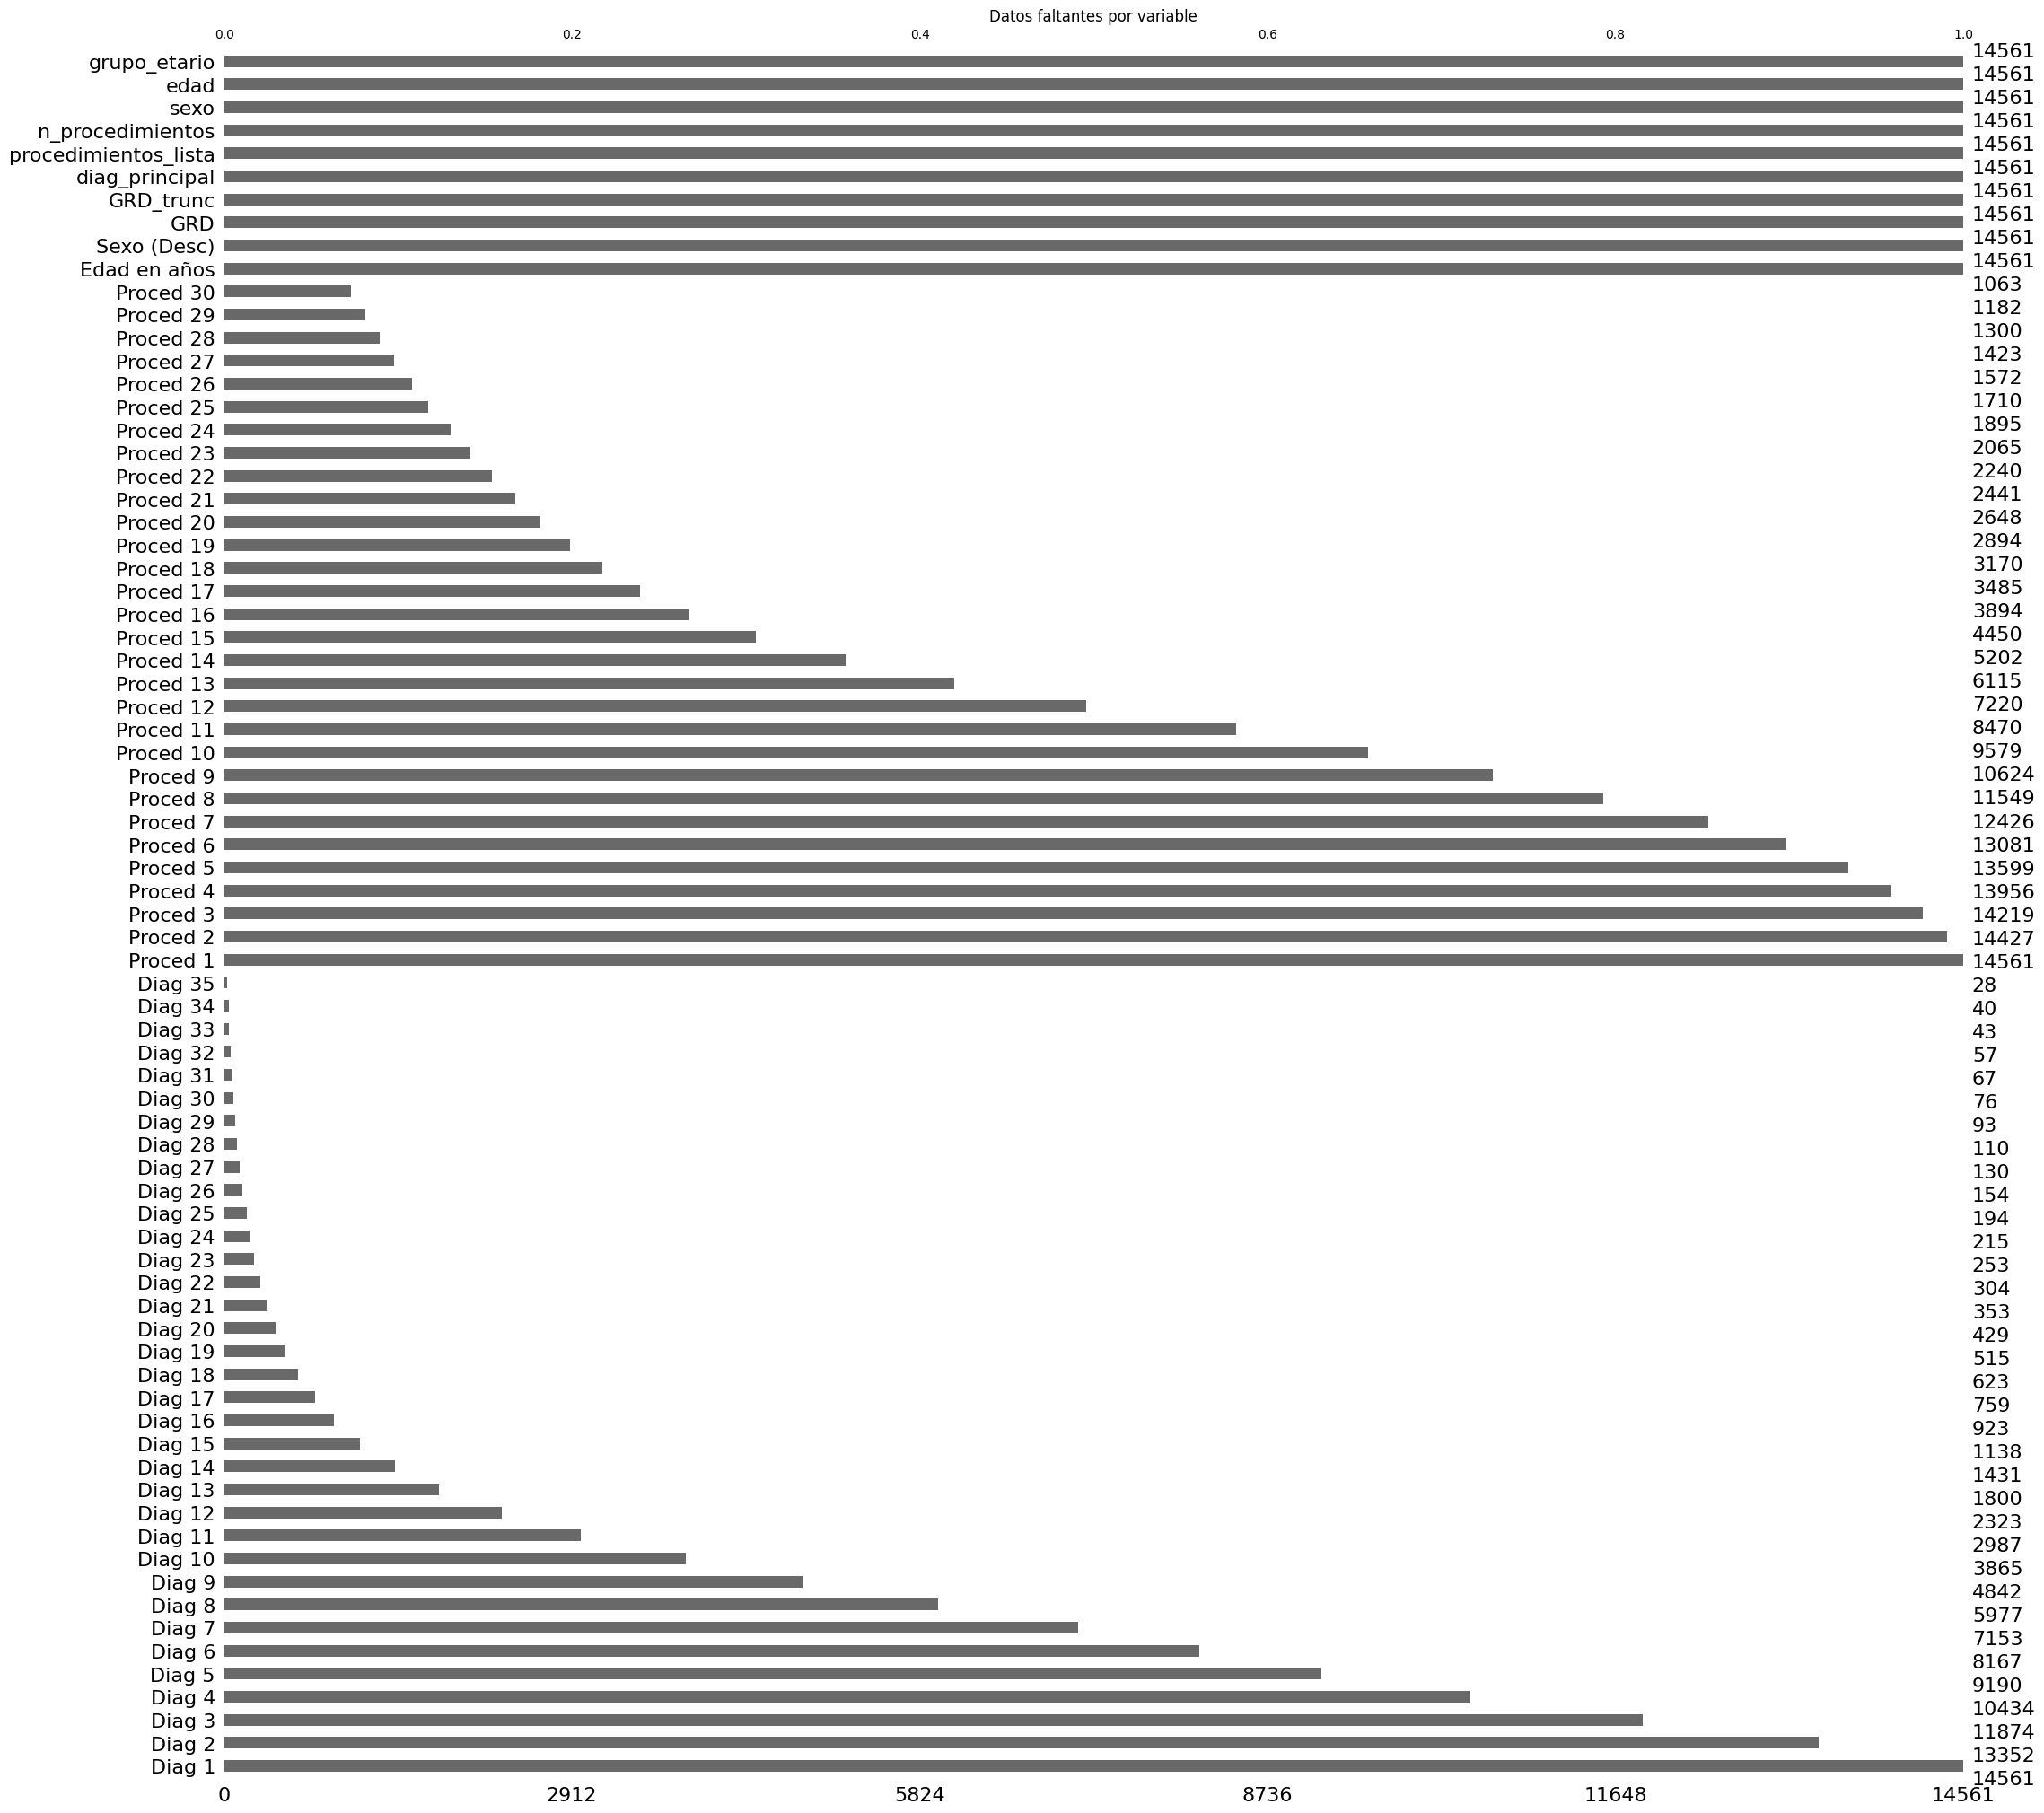

In [22]:
# 17.1 Renombrar columnas Diag* y Proced* para abreviar
diag_cols = [c for c in df.columns if c.startswith('Diag')]
proc_cols = [c for c in df.columns if c.startswith('Proced')]
rename_dict = {col: f"Diag {i+1}" for i, col in enumerate(diag_cols)}
rename_dict.update({col: f"Proced {i+1}" for i, col in enumerate(proc_cols)})
df = df.rename(columns=rename_dict)

# 17.2 Graficar datos faltantes por variable
plt.figure(figsize=(10, 6))
msno.bar(df)
plt.title('Datos faltantes por variable')
plt.show()

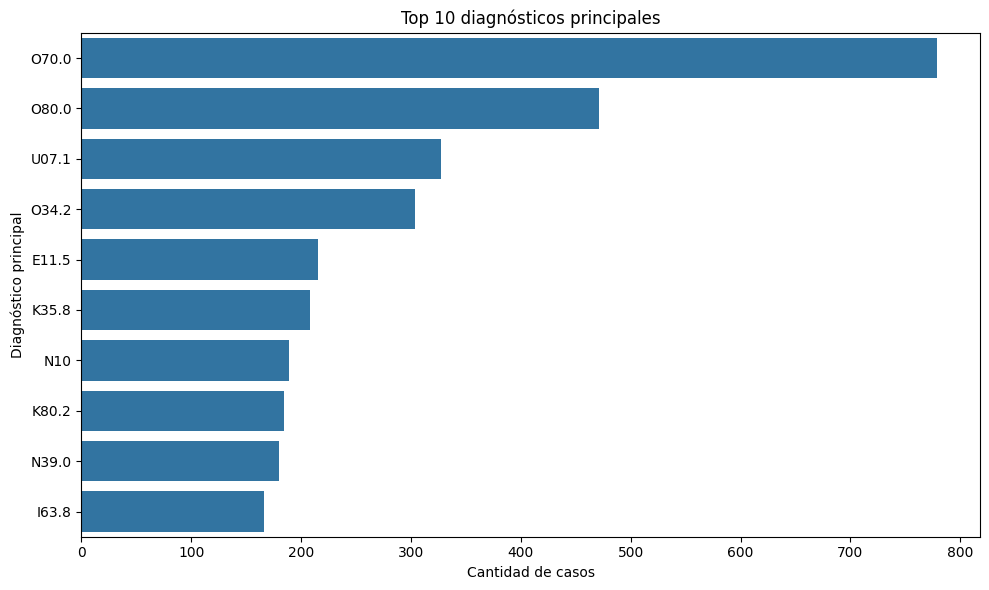

In [23]:
# 18.1 Graficar Top 10 diagnósticos principales
plt.figure(figsize=(10,6))
top10_diag = df['diag_principal'].value_counts().head(10)
sns.barplot(x=top10_diag.values, y=top10_diag.index)
plt.title("Top 10 diagnósticos principales")
plt.xlabel("Cantidad de casos")
plt.ylabel("Diagnóstico principal")
plt.tight_layout()
plt.show()

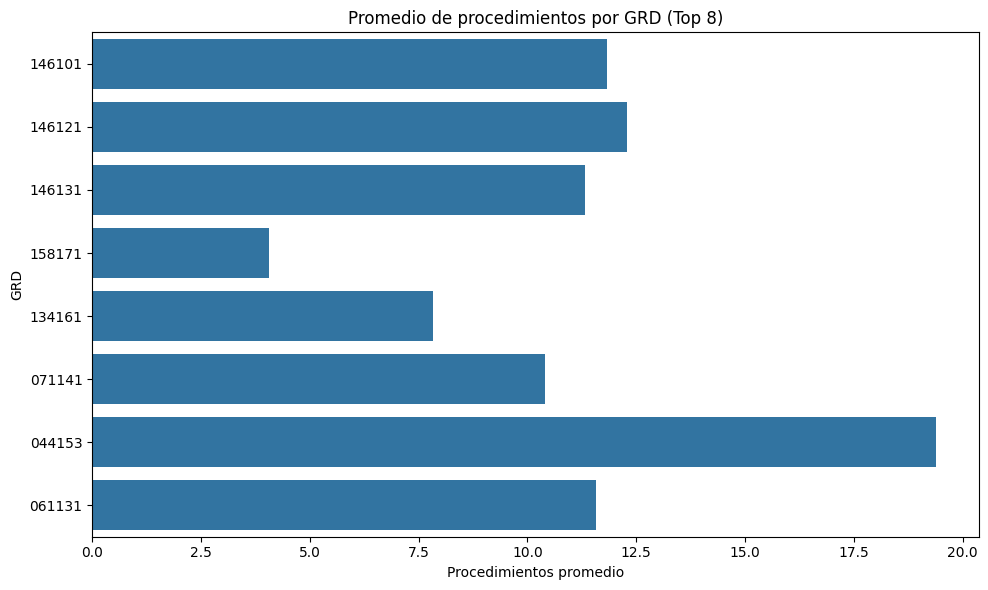

In [24]:
# 19.1 Graficar promedio de procedimientos por GRD (Top 8)
top8 = df['GRD'].value_counts().head(8).index
avg_proc = df.groupby('GRD')['n_procedimientos'].mean().loc[top8]
plt.figure(figsize=(10,6))
sns.barplot(x=avg_proc.values, y=avg_proc.index)
plt.title("Promedio de procedimientos por GRD (Top 8)")
plt.xlabel("Procedimientos promedio")
plt.ylabel("GRD")
plt.tight_layout()
plt.show()

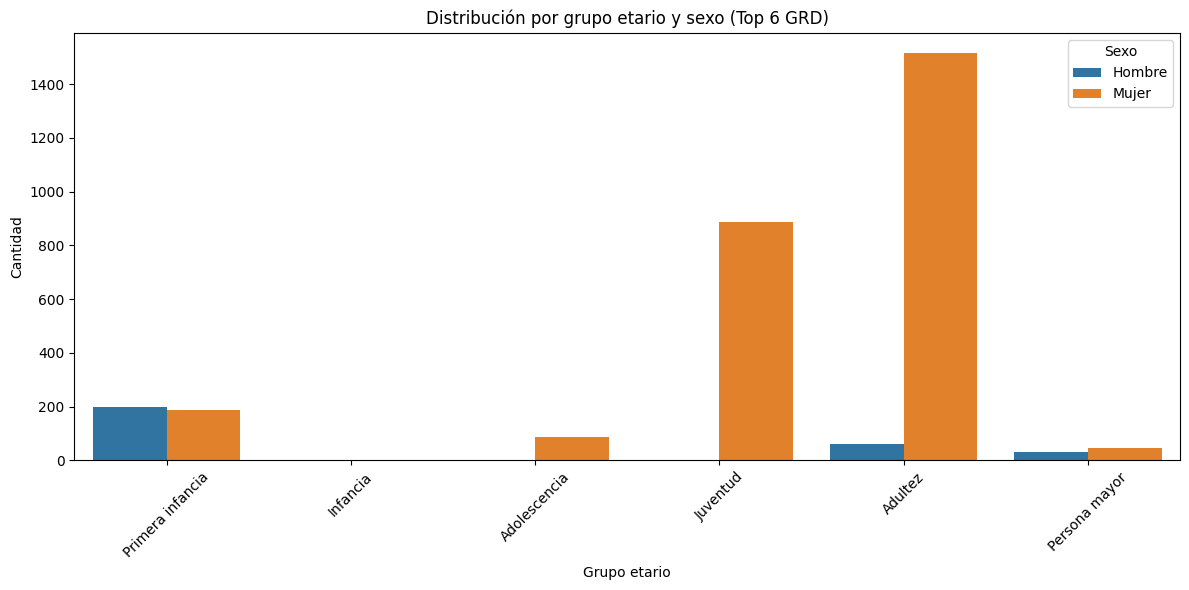

In [25]:
# 20.1 Graficar distribución por grupo etario y sexo (Top 6 GRD)
top6 = df['GRD'].value_counts().head(6).index
plt.figure(figsize=(12,6))
sns.countplot(data=df[df['GRD'].isin(top6)], x='grupo_etario', hue='sexo',
              order=['Primera infancia','Infancia','Adolescencia','Juventud','Adultez','Persona mayor'])
plt.title("Distribución por grupo etario y sexo (Top 6 GRD)")
plt.xlabel("Grupo etario")
plt.ylabel("Cantidad")
plt.xticks(rotation=45)
plt.legend(title="Sexo")
plt.tight_layout()
plt.show()

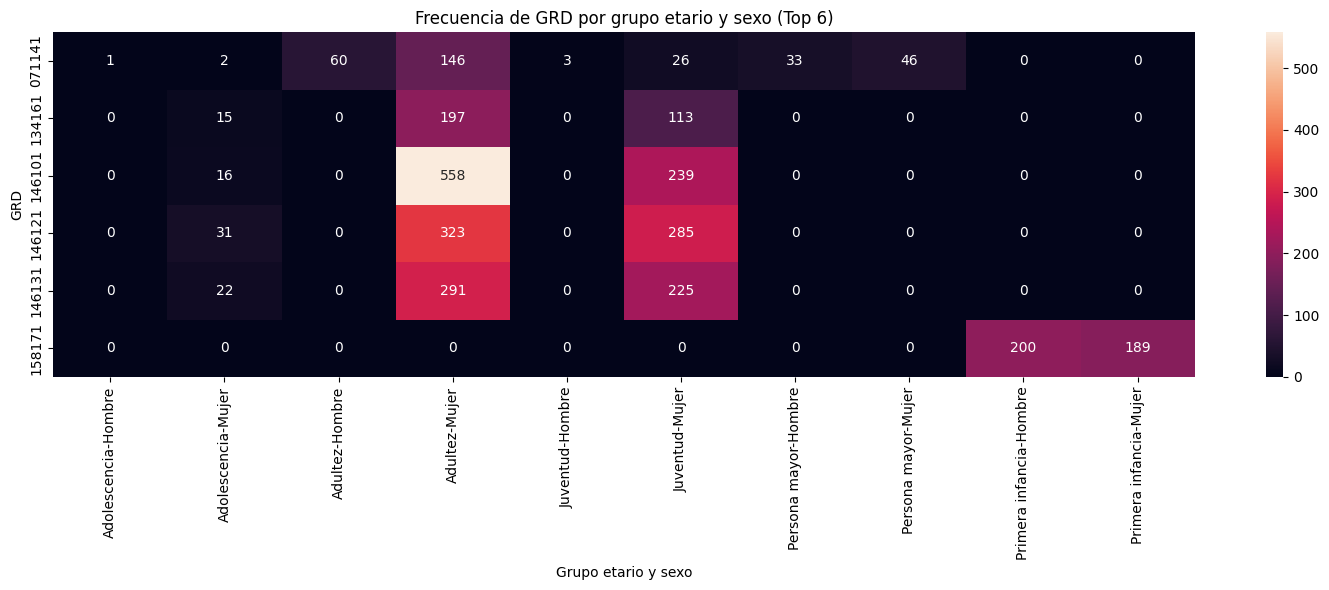

In [26]:
# 21.1 Crear heatmap de diag_principal por grupo etario y sexo
pivot = df[df['GRD'].isin(top6)].pivot_table(
    index='GRD', columns=['grupo_etario','sexo'], values='diag_principal',
    aggfunc='count', fill_value=0
)
plt.figure(figsize=(15,6))
sns.heatmap(pivot, annot=True, fmt='d')
plt.title("Frecuencia de GRD por grupo etario y sexo (Top 6)")
plt.xlabel("Grupo etario y sexo")
plt.ylabel("GRD")
plt.tight_layout()
plt.show()

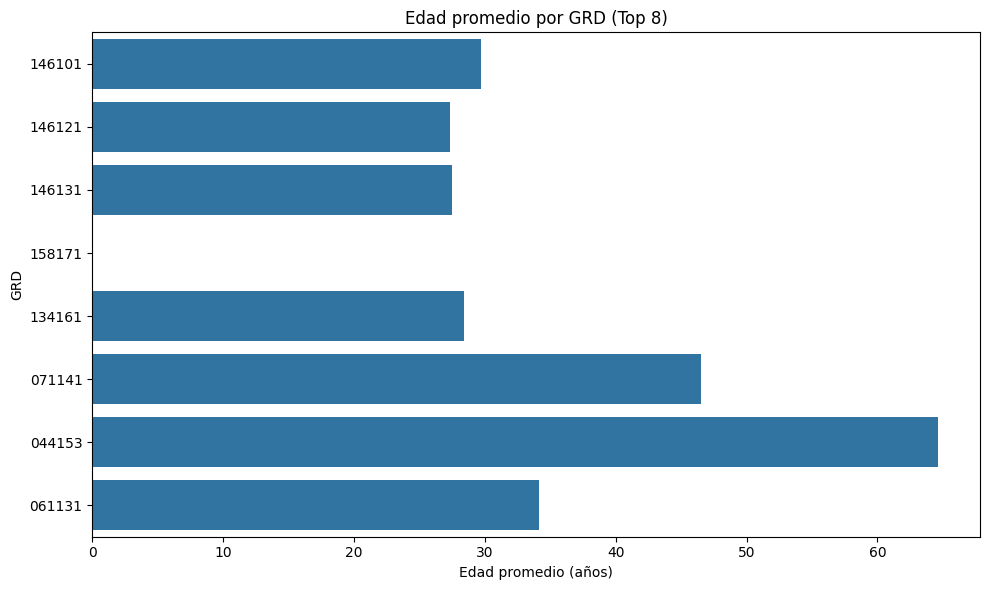

In [27]:
# 22.1 Graficar edad promedio por GRD (Top 8)
avg_age = df.groupby('GRD')['edad'].mean().loc[top8]
plt.figure(figsize=(10,6))
sns.barplot(x=avg_age.values, y=avg_age.index)
plt.title("Edad promedio por GRD (Top 8)")
plt.xlabel("Edad promedio (años)")
plt.ylabel("GRD")
plt.tight_layout()
plt.show()

In [31]:
# 23.1 Importar librerías para modelado avanzado
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, recall_score
import tensorflow as tf
from tensorflow.keras import Input, Model, regularizers
from tensorflow.keras.layers import Embedding, Flatten, Dense, Concatenate, BatchNormalization, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

In [32]:
# 24.1 Preparar datos para entrenamiento (filtro por soporte mínimo)
df_model = df.copy()
min_train = 15
train_frac = 0.8
min_total = int(np.ceil(min_train / train_frac))
valid = df['GRD_trunc'].value_counts()[df['GRD_trunc'].value_counts() >= min_total].index
df_model = df[df['GRD_trunc'].isin(valid)].reset_index(drop=True)

# 24.2 Codificar variable objetivo y features categóricas
le_grd = LabelEncoder(); df_model['grd_code'] = le_grd.fit_transform(df_model['GRD_trunc'])
le_diag = LabelEncoder(); df_model['diag_code'] = le_diag.fit_transform(df_model['diag_principal'])
le_age = LabelEncoder(); df_model['age_code'] = le_age.fit_transform(df_model['grupo_etario'])

# 24.3 Definir arrays de entrada numérica y categórica
X_num = df_model[['n_procedimientos']].values
X_diag = df_model['diag_code'].values
X_age = df_model['age_code'].values
y = df_model['grd_code'].values

# 24.4 Dividir datos en train y test estratificado
Xn_tr, Xn_te, d_tr, d_te, a_tr, a_te, y_tr, y_te = train_test_split(
    X_num, X_diag, X_age, y, test_size=0.2, stratify=y, random_state=42
)

# 24.5 Escalado numérico de variables (# 2.7 Escalado numérico)
scaler = StandardScaler()
Xn_tr = scaler.fit_transform(Xn_tr)
Xn_te = scaler.transform(Xn_te)

# 24.6 Calcular pesos de clase para entrenamiento
classes = np.unique(y_tr)
weights = compute_class_weight('balanced', classes=classes, y=y_tr)
class_weights = dict(zip(classes, weights))

# 24.7 Crear conjunto de validación interno
split_idx   = int(0.8 * len(Xn_tr))
Xn_tr_real  = Xn_tr[:split_idx];  d_tr_real = d_tr[:split_idx];  a_tr_real = a_tr[:split_idx];  y_tr_real = y_tr[:split_idx]
Xn_val      = Xn_tr[split_idx:];  d_val      = d_tr[split_idx:];  a_val      = a_tr[split_idx:];  y_val     = y_tr[split_idx:]

In [33]:
# 25.1 Definir arquitectura del modelo MLP con embeddings
n_diag = len(le_diag.classes_); n_age = len(le_age.classes_); n_grd = len(le_grd.classes_)
inp_num = Input(shape=(1,), name='num_input')
inp_diag = Input(shape=(1,), name='diag_input')
inp_age = Input(shape=(1,), name='age_input')
emb_diag = Embedding(input_dim=n_diag, output_dim=16)(inp_diag)
flat_diag = Flatten()(emb_diag)
emb_age = Embedding(input_dim=n_age, output_dim=4)(inp_age)
flat_age = Flatten()(emb_age)
x = Concatenate()([inp_num, flat_diag, flat_age])
x = Dense(124, activation='relu')(x)
x = Dense(64, activation='relu')(x)
out = Dense(n_grd, activation='softmax', name='grd_output')(x)
model = Model([inp_num, inp_diag, inp_age], out)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ diag_input          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ age_input           │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 1, 16)     │     19,888 │ diag_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 1, 4)      │         24 │ age_input[0][0]   │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ num_input           │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 16)        │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 4)         │          0 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 21)        │          0 │ num_input[0][0],  │
│ (Concatenate)       │                   │            │ flatten[0][0],    │
│                     │                   │            │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 124)       │      2,728 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,000 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ grd_output (Dense)  │ (None, 106)       │      6,890 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 37,530 (146.60 KB)

 Trainable params: 37,530 (146.60 KB)

 Non-trainable params: 0 (0.00 B)

In [34]:
# 26.1 Definir callback personalizado para calcular recall en validación
class RecallCallback(tf.keras.callbacks.Callback):
    def __init__(self, Xn_val, d_val, a_val, y_val):
        super().__init__()
        self.Xn_val = Xn_val; self.d_val = d_val; self.a_val = a_val; self.y_val = y_val
    def on_epoch_end(self, epoch, logs=None):
        probs = self.model.predict([self.Xn_val, self.d_val, self.a_val], verbose=0)
        y_pred = np.argmax(probs, axis=1)
        rec = recall_score(self.y_val, y_pred, average='macro', zero_division=0)
        logs = logs or {}
        logs['val_recall'] = rec
        print(f' — val_recall: {rec:.4f}')

# 26.2 Configurar callbacks de entrenamiento
recall_cb = RecallCallback(Xn_val, d_val, a_val, y_val)
es = EarlyStopping(monitor='val_recall', mode='max', patience=5, restore_best_weights=True, verbose=1)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

In [35]:
# 27.1 Entrenar modelo
history = model.fit(
    x=[Xn_tr_real, d_tr_real, a_tr_real],
    y=y_tr_real,
    validation_data=([Xn_val, d_val, a_val], y_val),
    batch_size=37530, epochs=100,
    class_weight=class_weights,
    callbacks=[recall_cb, es, rlr]
)

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.0069 - loss: 4.6418 — val_recall: 0.0091
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.0069 - loss: 4.6418 - val_accuracy: 0.0108 - val_loss: 4.6631 - val_recall: 0.0091 - learning_rate: 0.0010
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.0064 - loss: 4.6371 — val_recall: 0.0154
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.0064 - loss: 4.6371 - val_accuracy: 0.0117 - val_loss: 4.6595 - val_recall: 0.0154 - learning_rate: 0.0010
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step - accuracy: 0.0116 - loss: 4.6324 — val_recall: 0.0175
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.0116 - loss: 4.6324 - val_accuracy: 0.0126 - val_loss: 4.6557 - val_recall: 0.0175 - learning_rate: 0.0010
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - accuracy: 0.0141 - loss: 4.6278 — val_recall: 0.0205
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.0141 - loss: 4.6278 - val_accuracy: 0.0153 - val_loss: 4.6


Test → Loss: 1.314 — Acc: 0.752 — Recall: 0.698

              precision    recall  f1-score   support

       01413       0.67      0.57      0.62         7
       01414       0.97      0.91      0.94        43
       01416       1.00      1.00      1.00         4
       01422       0.94      1.00      0.97        16
       01423       1.00      0.80      0.89         5
       01424       0.94      0.97      0.95        30
       03413       0.53      1.00      0.69        10
       04101       0.17      0.47      0.25        15
       04102       0.33      0.08      0.13        51
       04120       0.38      0.09      0.14        35
       04411       0.90      1.00      0.95        19
       04412       0.94      1.00      0.97        15
       04415       0.86      0.82      0.84        68
       04416       0.97      0.95      0.96        64
       04417       0.96      0.90      0.93        30
       04418       0.98      1.00      0.99        42
       04419       1.00      1.

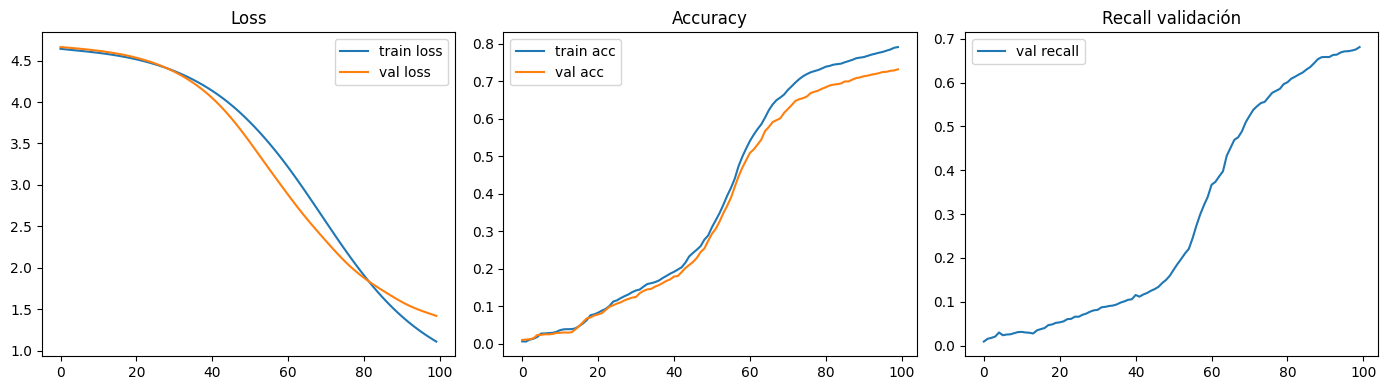

In [36]:
# 28.1 Evaluar modelo en conjunto de test
test_loss, test_acc = model.evaluate([Xn_te, d_te, a_te], y_te, verbose=0)
probs = model.predict([Xn_te, d_te, a_te], verbose=0)
y_pred = np.argmax(probs, axis=1)
test_rec = recall_score(y_te, y_pred, average='macro', zero_division=0)
print(f"\nTest → Loss: {test_loss:.3f} — Acc: {test_acc:.3f} — Recall: {test_rec:.3f}\n")
labels = np.unique(y_te)
names = [le_grd.classes_[i] for i in labels]
print(classification_report(y_te, y_pred, labels=labels, target_names=names, zero_division=0))

# 28.2 Graficar métricas de entrenamiento y validación
plt.figure(figsize=(14,4))
plt.subplot(1,3,1)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss'); plt.legend()
plt.subplot(1,3,2)
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.title('Accuracy'); plt.legend()
plt.subplot(1,3,3)
plt.plot(history.history['val_recall'], label='val recall')
plt.title('Recall validación'); plt.legend()
plt.tight_layout()
plt.show()

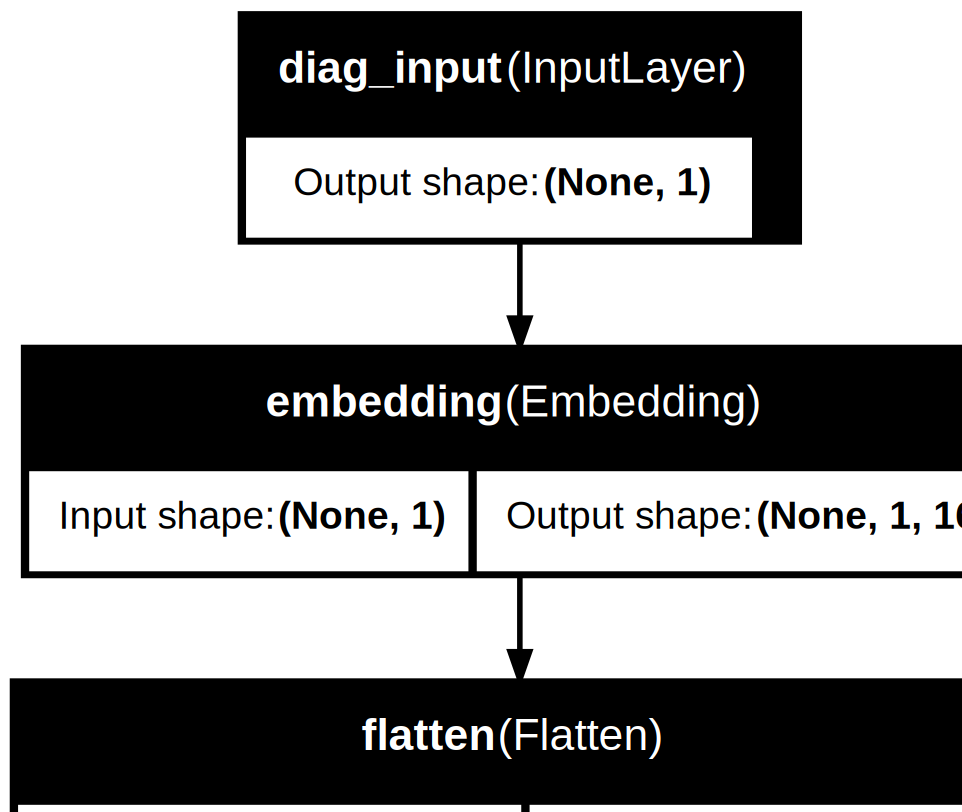

In [37]:
from tensorflow.keras.utils import plot_model, model_to_dot
from IPython.display import SVG, Image

plot_model(
    model,
    to_file='modelo_grd.png',
    show_shapes=True,
    show_layer_names=True,
    expand_nested=False
)

Image(filename='modelo_grd.png')

svg = model_to_dot(model, show_shapes=True).create(prog='dot', format='svg')
display(SVG(svg))